In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('../data/hmeq_clean.csv',index_col=0)
X = data.drop(columns=['BAD'])
y = data['BAD']

I am going to test the recommendations with both models, Random Forest and Logistic Regression

In [3]:
model_rf = RandomForestClassifier(n_estimators=200)
model_rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [4]:
model_lr = LogisticRegression()
model_lr.fit(X,y)

/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [137]:
tom = pd.Series({'LOAN': 100000,
 'MORTDUE': 47000,
 'VALUE': 20000,
 'YOJ': 2.0,
 'DEROG': 0,
 'DELINQ': 0,
 'CLAGE': 50,
 'CLNO': 10,
 'DEBTINC': 50,
 'NINQ': 0,
 'REASON_DebtCon':1,
 'REASON_HomeImp':0,
 'JOB_Mgr':0,
 'JOB_Office':0,
 'JOB_Other':0,
 'JOB_ProfExe':0,
 'JOB_Sales':0,
 'JOB_Self':1})

In [6]:
model_rf.predict(pd.DataFrame(tom).T)[0]

1

In [7]:
model_lr.predict(pd.DataFrame(tom).T)[0]

1

Tom does not pass either test

# Recommendation system

In [8]:
data_pos = data.loc[data['BAD']==0]
data_pos.drop(columns=['BAD'],inplace=True)
data_pos = data_pos.T

/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
# I include Tom in the positive database
data_pos['TOM'] = tom

In [10]:
distances = pd.DataFrame(1/(1 + squareform(pdist(data_pos.T, 'euclidean'))), 
                         index=data_pos.columns, columns=data_pos.columns)

similarities = distances['TOM'].sort_values(ascending=False)[1:]

similars = pd.DataFrame(similarities)
similars[:5]

,TOM
5870,0.000016
5814,0.000016
5878,0.000016
5894,0.000016
5899,0.000016


In [11]:
data_pos[["TOM",5870]] # Comparing with the most similar person who has paid, but I realise 
                       # there are some variables such as CLNO which I can not change.

,TOM,5870
LOAN,100000.0,52900.000000
MORTDUE,47000.0,48825.000000
VALUE,20000.0,59418.000000
YOJ,2.0,13.000000
DEROG,0.0,0.000000
DELINQ,0.0,0.000000
CLAGE,50.0,102.338683
NINQ,0.0,1.000000
CLNO,10.0,25.000000
DEBTINC,50.0,38.751995


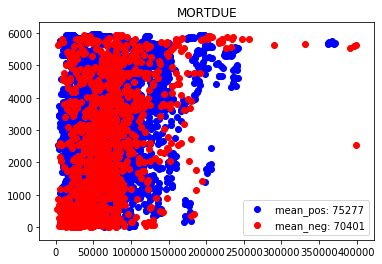

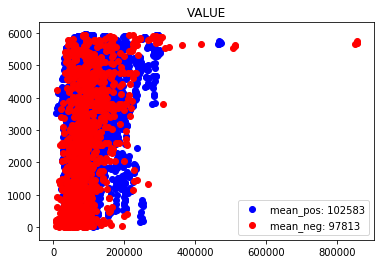

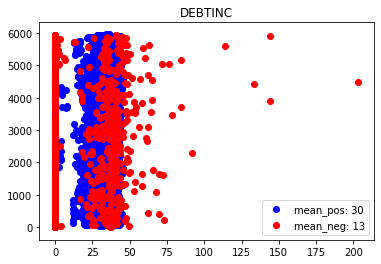

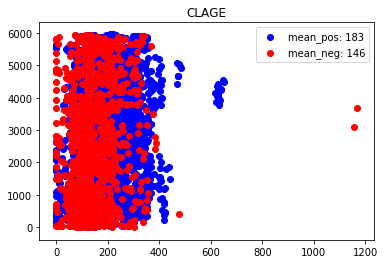

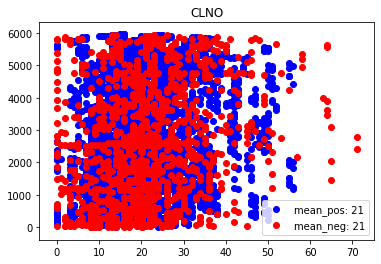

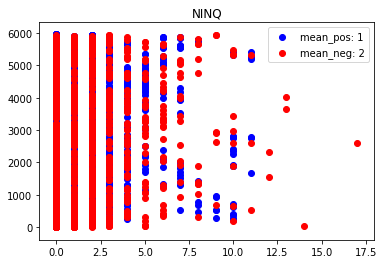

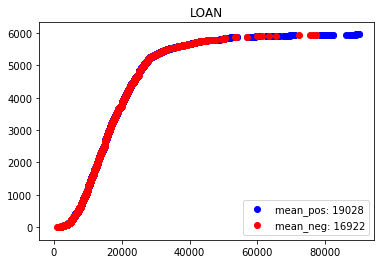

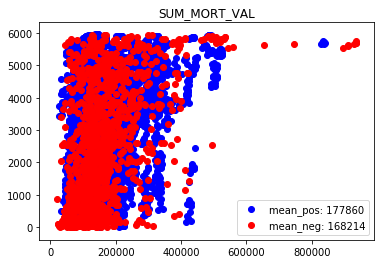

In [13]:
data_copy = data.copy()
data_copy['SUM_MORT_VAL']=data[['MORTDUE','VALUE']].apply(sum,axis=1)
def relationship(col):
    x_pos = data_copy[data_copy['BAD']==0][col]
    y_pos = x_pos.index
    x_neg = data_copy[data_copy['BAD']==1][col]
    y_neg = x_neg.index
    mean_pos = round(x_pos.mean())
    mean_neg = round(x_neg.mean())
    plt.figure()
    plt.title(col)
    plt.scatter(x_pos,y_pos,color='blue')
    plt.scatter(x_neg,y_neg,color='red')
    plt.legend(('mean_pos: ' + str(mean_pos),'mean_neg: '+str(mean_neg)))

variables = ['MORTDUE','VALUE','DEBTINC','CLAGE','CLNO','NINQ','LOAN','SUM_MORT_VAL']
[relationship(col) for col in variables];

There is so little correlation between pay and not pay and the other variables that there is no guaratee that if I change some of them it will pass the test. So in the while loop I will do after, I am going to trace a line and that line may not ever cut the model's hyperplane, because that line is intuitive. I will see what I can do.

In [14]:
# cols = variables I can not change in Tom
cols = ['JOB_Self','JOB_Mgr','JOB_Other','JOB_Office','JOB_ProfExe',
        'REASON_DebtCon','REASON_HomeImp','DEROG','DELINQ']
# bigger = variables that are better to be larger than tom's 
bigger = ['MORTDUE','CLNO','NINQ']
# smaller = variables that are better to be smaller than tom's
smaller = ['LOAN','CLAGE','DEBTINC']
df_empty = pd.DataFrame({title:[] for title in data_pos.index})
for i in similars.index:
    if [data_pos[i][col] == tom[col] for col in cols]==[True]*len(cols):
        if data_pos[i]['DEBTINC'] <= tom['DEBTINC']:
            df_empty = pd.concat([df_empty,pd.DataFrame(data_pos[i]).T])

df_empty = df_empty.sort_values(by='YOJ',ascending=True)
display(df_empty.head());

#Supposing DEBTINC is not changeable and high ratios are better (graphics don't show this)


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
4623,24200.0,90626.0,116601.0,2.0,0.0,0.0,226.116387,1.0,27.0,34.499938,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4261,22200.0,93947.0,116176.0,2.0,0.0,0.0,205.029409,2.0,26.0,34.939403,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4658,24400.0,95843.0,123377.0,2.0,0.0,0.0,201.976756,1.0,26.0,32.903468,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4484,23400.0,97865.0,120172.0,2.0,0.0,0.0,200.575752,1.0,26.0,36.398729,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4085,21400.0,88147.0,115000.0,3.0,0.0,0.0,213.233333,2.0,27.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
tom1 = pd.Series({'LOAN': 24200,
 'MORTDUE': 90626,
 'VALUE': 11700,
 'YOJ': 2.0,
 'DEROG': 0,
 'DELINQ': 0,
 'CLAGE': 227,
 'CLNO': 26,
 'DEBTINC': 35,
 'NINQ': 1,
 'REASON_DebtCon':1,
 'REASON_HomeImp':0,
 'JOB_Mgr':0,
 'JOB_Office':0,
 'JOB_Other':0,
 'JOB_ProfExe':0,
 'JOB_Sales':0,
 'JOB_Self':1})
print(model_lr.predict(pd.DataFrame(tom1).T)[0])
model_rf.predict(pd.DataFrame(tom1).T)[0]
# Works for logistic regression model but not for random forest

0


1

Now I am going to try to find the intersection between two hyperplanes, one defined by me in the while and the other one of the model, the cut must pass the test, but maybe they don't cut... In that case I say I cant be able to give Tom any tips

In [16]:
tom2 = tom.copy()
while model_rf.predict(pd.DataFrame(tom2).T)[0] == 1:
    if tom2['LOAN'] > 1000:
        tom2['LOAN'] -= 1000
    else:
        print('WONT PASS THE TEST')
        break
    if tom2['MORTDUE'] > 1000:
        tom2['MORTDUE'] -= 1000
    else:
        tom2['VALUE'] += tom2['MORTDUE']
        tom2['MORTDUE'] = 0
    tom2['CLAGE'] += 1
    tom2['YOJ'] += 0.1
tom2

WONT PASS THE TEST


LOAN               1000.0
MORTDUE               0.0
VALUE             21000.0
YOJ                  11.9
DEROG                 0.0
DELINQ                0.0
CLAGE               149.0
CLNO                 10.0
DEBTINC              50.0
NINQ                  0.0
REASON_DebtCon        1.0
REASON_HomeImp        0.0
JOB_Mgr               0.0
JOB_Office            0.0
JOB_Other             0.0
JOB_ProfExe           0.0
JOB_Sales             0.0
JOB_Self              1.0
dtype: float64

In [17]:
print(model_rf.predict(pd.DataFrame(tom2).T)[0])
model_lr.predict(pd.DataFrame(tom2).T)[0]

1


1

In [18]:
# Won't pass the test
tom3 = tom.copy()
i = 0
while model_rf.predict(pd.DataFrame(tom3).T)[0] == 1 and i < 50:
    i+=1
    tom3['LOAN'] += 1000
    if tom3['MORTDUE'] > 1000:
        tom3['MORTDUE'] -= 1000
    else:
        tom3['VALUE'] += tom3['MORTDUE']
        tom3['MORTDUE'] = 0
    tom3['CLAGE'] += 1
    tom3['YOJ'] += 0.1
print(model_rf.predict(pd.DataFrame(tom2).T)[0])
model_lr.predict(pd.DataFrame(tom2).T)[0]

1


1

In [54]:
tom4 = tom.copy()
# IF you want your entire loan but are willing to wait
i = 0
while model_rf.predict(pd.DataFrame(tom3).T)[0] == 1 and i < 150:
    i+=1
    tom4['CLAGE'] += 2 #Two months
    tom4['YOJ'] += 0.2
print(model_rf.predict(pd.DataFrame(tom4).T)[0])
print(model_lr.predict(pd.DataFrame(tom4).T)[0])
tom4

1
0


LOAN              100000.0
MORTDUE            47000.0
VALUE              20000.0
YOJ                   32.0
DEROG                  0.0
DELINQ                 0.0
CLAGE                350.0
CLNO                  10.0
DEBTINC               50.0
NINQ                   0.0
REASON_DebtCon         1.0
REASON_HomeImp         0.0
JOB_Mgr                0.0
JOB_Office             0.0
JOB_Other              0.0
JOB_ProfExe            0.0
JOB_Sales              0.0
JOB_Self               1.0
dtype: float64

Now I am going to use a model to predict Loan with the bad variable set to 0 and use the prediction to test the model.

In [58]:
model_lr2 = LogisticRegression()
model_lr2.fit(data.drop(columns=['LOAN']),data['LOAN'])

/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [55]:
tom5 = pd.Series({'BAD': 0,
 'MORTDUE': 47000,
 'VALUE': 200000,
 'YOJ': 2.0,
 'DEROG': 0,
 'DELINQ': 0,
 'CLAGE': 200,
 'CLNO': 10,
 'DEBTINC': 5,
 'NINQ': 0,
 'REASON_DebtCon':1,
 'REASON_HomeImp':0,
 'JOB_Mgr':0,
 'JOB_Office':0,
 'JOB_Other':0,
 'JOB_ProfExe':0,
 'JOB_Sales':0,
 'JOB_Self':1})

In [56]:
tom6 = pd.Series({'BAD': 1,
 'MORTDUE': 680000,
 'VALUE': 50000,
 'YOJ': 2.0,
 'DEROG': 0,
 'DELINQ': 0,
 'CLAGE': 50,
 'CLNO': 10,
 'DEBTINC': 10,
 'NINQ': 0,
 'REASON_DebtCon':1,
 'REASON_HomeImp':0,
 'JOB_Mgr':0,
 'JOB_Office':0,
 'JOB_Other':0,
 'JOB_ProfExe':0,
 'JOB_Sales':0,
 'JOB_Self':1})

In [61]:
tom5_prediction = model_lr2.predict(pd.DataFrame(tom).T)[0]
tom5_prediction

77400

In [62]:
tom5_loan = pd.Series({'LOAN': tom5_prediction,
 'MORTDUE': 47000,
 'VALUE': 200000,
 'YOJ': 2.0,
 'DEROG': 0,
 'DELINQ': 0,
 'CLAGE': 200,
 'CLNO': 10,
 'DEBTINC': 5,
 'NINQ': 0,
 'REASON_DebtCon':1,
 'REASON_HomeImp':0,
 'JOB_Mgr':0,
 'JOB_Office':0,
 'JOB_Other':0,
 'JOB_ProfExe':0,
 'JOB_Sales':0,
 'JOB_Self':1})

In [65]:
print(model_lr.predict(pd.DataFrame(tom5_loan).T)[0])
model_rf.predict(pd.DataFrame(tom5_loan).T)[0] #Nothing works with random forest :/

0


1

In [66]:
#BUT THE PREDICTION IS NOT THE MAXIMUM LOAN TOM CAN ASK FOR

In [69]:
from sklearn.ensemble import RandomForestRegressor

In [70]:
# Try to predict a loan with a different model
regr = RandomForestRegressor(max_depth=24, random_state=0)
X = data.drop(columns=['LOAN'])
y = data['LOAN']
regr.fit(X, y)

/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=24,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [71]:
regr_r = RandomForestRegressor(max_depth=24, random_state=0)
X = data.drop(columns=['BAD'])
y = data['BAD']
regr_r.fit(X, y)

/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=24,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [74]:
tom5_loan = regr.predict(pd.DataFrame(tom5).T)[0]
tom5_loan

45620.0

In [116]:
tom5_result = pd.Series({'LOAN': tom5_loan,
 'MORTDUE': 680000,
 'VALUE': 50000,
 'YOJ': 2.0,
 'DEROG': 0,
 'DELINQ': 0,
 'CLAGE': 50,
 'CLNO': 10,
 'DEBTINC': 10,
 'NINQ': 0,
 'REASON_DebtCon':1,
 'REASON_HomeImp':0,
 'JOB_Mgr':0,
 'JOB_Office':0,
 'JOB_Other':0,
 'JOB_ProfExe':0,
 'JOB_Sales':0,
 'JOB_Self':1})

In [118]:
print(regr_r.predict(pd.DataFrame(tom5_result).T)[0]) # RESULT = DOESNT PAY -> WRONG
model_lr.predict(pd.DataFrame(tom5_result).T)[0]

0.6


0

In [151]:
coefs = model_lr.coef_[0]
intercept = model_lr.intercept_[0]

In [152]:
model_lr.predict(pd.DataFrame(tom).T)[0]

1

In [153]:
n = coefs
#n = np.add(n,tom.values)
n /= np.linalg.norm(coefs)

In [154]:
x = -intercept/n[0]
x*n[0]+intercept # A POINT CONTAINED IN THE PLANE

0.0

In [155]:
p0 = [0]*17 
p0.insert(0,x)
p0 #THIS IS THE POINT IN THE PLANE

[93.79142545269667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [156]:
np.dot(p0,n)+intercept # THAT'S WHY THIS IS ZERO

0.0

In [157]:
p_ = tom.values - p0 #VECTOR FROM POINT TO HYPERPLANE
dist_to_plane = np.dot(p_, n)

In [158]:
dist_to_plane

12.679751593369065

In [159]:
p_normal = np.dot(p_, n) * n
p_tangent = p_ - p_normal

In [160]:
closest_point = p_tangent + p0
closest_point

array([ 1.00000000e+05,  4.70000002e+04,  1.99999994e+04,  1.89643220e+00,
       -1.23406955e+00, -2.24816966e+00,  5.08180246e+01,  8.30143959e+00,
        4.61200423e+01,  1.16404268e+01,  1.00885281e+00, -1.42995880e-01,
       -8.21278620e-02,  1.13523328e-01, -1.64090627e-01,  9.33647489e-02,
       -4.88904843e-02,  9.54077823e-01])

In [161]:
tom7 = tom.copy()
tom7

LOAN              100000.0
MORTDUE            47000.0
VALUE              20000.0
YOJ                    2.0
DEROG                  0.0
DELINQ                 0.0
CLAGE                 50.0
CLNO                  10.0
DEBTINC               50.0
NINQ                   0.0
REASON_DebtCon         1.0
REASON_HomeImp         0.0
JOB_Mgr                0.0
JOB_Office             0.0
JOB_Other              0.0
JOB_ProfExe            0.0
JOB_Sales              0.0
JOB_Self               1.0
dtype: float64

In [162]:
for i in range(12):
    tom7[tom7.keys()[i]] = closest_point[i]
tom7 # THIS POINT IS NOT REACHABLE 

LOAN              100000.000097
MORTDUE            47000.000234
VALUE              19999.999444
YOJ                    1.896432
DEROG                 -1.234070
DELINQ                -2.248170
CLAGE                 50.818025
CLNO                   8.301440
DEBTINC               46.120042
NINQ                  11.640427
REASON_DebtCon         1.008853
REASON_HomeImp        -0.142996
JOB_Mgr                0.000000
JOB_Office             0.000000
JOB_Other              0.000000
JOB_ProfExe            0.000000
JOB_Sales              0.000000
JOB_Self               1.000000
dtype: float64

In [163]:
model_lr.predict(pd.DataFrame(tom7).T)[0]

1

In [164]:
closest_point

array([ 1.00000000e+05,  4.70000002e+04,  1.99999994e+04,  1.89643220e+00,
       -1.23406955e+00, -2.24816966e+00,  5.08180246e+01,  8.30143959e+00,
        4.61200423e+01,  1.16404268e+01,  1.00885281e+00, -1.42995880e-01,
       -8.21278620e-02,  1.13523328e-01, -1.64090627e-01,  9.33647489e-02,
       -4.88904843e-02,  9.54077823e-01])

In [165]:
# IT SHOULD BE ZERO BUT PYTHON LOOSES PRECISION THAT'S WHY IT DOES NOT PASS THE TEST
np.dot(closest_point,coefs) + intercept

1.5248219353836134e-15

In [170]:
for i in range(12): #MOVING THE POINT A LITTLE BIT IT DOES PASS THE TEST
    tom7[tom7.keys()[i]] += 1

In [172]:
model_lr.predict(pd.DataFrame(tom7).T)[0]

0

In [173]:
tom7

LOAN              100001.000097
MORTDUE            47001.000234
VALUE              20000.999444
YOJ                    2.896432
DEROG                 -0.234070
DELINQ                -1.248170
CLAGE                 51.818025
CLNO                   9.301440
DEBTINC               47.120042
NINQ                  12.640427
REASON_DebtCon         2.008853
REASON_HomeImp         0.857004
JOB_Mgr                0.000000
JOB_Office             0.000000
JOB_Other              0.000000
JOB_ProfExe            0.000000
JOB_Sales              0.000000
JOB_Self               1.000000
dtype: float64

In [174]:
tom8 = tom.copy()

In [175]:
while model_lr.predict(pd.DataFrame(tom8).T)[0]==1:
    if tom8['LOAN'] <= 100:
        break
    tom8['LOAN'] -= 1000
    if tom8['MORTDUE'] > 2000:
        tom8['MORTDUE'] -= 2000
    else: 
        tom8['MORTDUE'] = 0
    if tom8['MORTDUE'] > 2000:
        tom8['VALUE'] += 2000
    else: 
        tom8['VALUE'] += tom8['MORTDUE']
    tom8['YOJ'] += 0.1
    tom8['CLAGE'] += 1

In [176]:
tom8

LOAN                  1.0
MORTDUE               0.0
VALUE             65002.0
YOJ                  13.0
DEROG                 1.0
DELINQ                1.0
CLAGE               151.0
CLNO                 11.0
DEBTINC              51.0
NINQ                  1.0
REASON_DebtCon        2.0
REASON_HomeImp        1.0
JOB_Mgr               0.0
JOB_Office            0.0
JOB_Other             0.0
JOB_ProfExe           0.0
JOB_Sales             0.0
JOB_Self              1.0
dtype: float64